# **Clasificador bayesiano**
Un clasificador bayesiano es un clasificador que, dado un vector de características, elige cuál es la clase más probable de la muestra. A continuación se presentan 2 clasificadores implementados por medio de numpy, que utilizan diferentes hipótesis para entregar un resultado.

El dataset utilizado en este notebook corresponde al [HTRU2](https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip), el cual contiene información para la clasificación de candidatos de pulsares.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Para trabajar con los datos que contiene el dataset se ha creado un DataFrame con la información del archivo csv. La lista *headers* contiene los nombres de cada una de las columnas.

In [2]:
# El archivo "HTRU_2.csv" debe encontrarse en el mismo directorio que este notebook. De no ser así, proporcione
# la ubicación del archivo en la variable path.
path = "HTRU/HTRU_2.csv"
headers = ['mean_prof','std_prof','exkurt_prof','skew_prof','mean_curve','std_curve','exkurt_curve','skew_curve','class']
data = pd.read_csv(path, names=headers)

Visualización de las primeras 5 filas del DataFrame.

In [3]:
data.head()

,mean_prof,std_prof,exkurt_prof,skew_prof,mean_curve,std_curve,exkurt_curve,skew_curve,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


A continuación, se implementa una función que recibe como parámetro un DataFrame, y se retorna una lista que en cada posición contiene un DataFrame con todas las muestras de una clase.

In [4]:
def class_split(dataset):
    # Se asume que las clases se encuentran en la última columna.
    labels_col = dataset.columns[-1]
    classes = dataset[labels_col].drop_duplicates()

    data_by_classes = []
    for class_ in classes:
        data_by_classes.append(dataset.loc[dataset[labels_col] == class_])

    return data_by_classes

Se puede ver que en este caso, la variable *pulsar* sólo contiene datos cuya clase es igual a 1.

In [5]:
no_pulsar, pulsar = class_split(data)
pulsar.head()


,mean_prof,std_prof,exkurt_prof,skew_prof,mean_curve,std_curve,exkurt_curve,skew_curve,class
19,99.367188,41.572202,1.547197,4.154106,27.555184,61.719016,2.208808,3.662680,1
42,120.554688,45.549905,0.282924,0.419909,1.358696,13.079034,13.312141,212.597029,1
61,27.765625,28.666042,5.770087,37.419009,73.112876,62.070220,1.268206,1.082920,1
92,23.625000,29.948654,5.688038,35.987172,146.568562,82.394624,-0.274902,-1.121848,1
93,94.585938,35.779823,1.187309,3.687469,6.071070,29.760400,5.318767,28.698048,1


Luego, para generar un conjunto de training y otro de test, se ha implementado la siguiente función. Esta función recibe como parámetros un DataFrame que contiene todas las muestras, un float entre 0 y 1 que indica la fracción de los datos que se destinarán al conjunto de training, una semilla cuya utilidad radica en la reproductibilidad de la partición, y un flag que indica si el conjunto de entrenamiento debe ser entregado por clases o en un único DataFrame.

Se debe notar que esta función preserva la relación que existe entre las cantidades de muestras de cada clase, de modo que una fracción *train_size* de muestras de cada clase es destinada al conjunto de entrenamiento.

In [6]:
def train_test_split(dataset, train_size, seed=None, by_class=False):
    # Se reordena el conjunto de datos para evitar posibles sesgos po un orden predeterminado.
    shuffled_data = dataset.sample(frac=1, random_state=seed)

    # Se particionan los datos por clases para obtener la misma proporción de cada uno de ellos.
    data_by_classes = class_split(shuffled_data)
    num_classes = len(data_by_classes)
    
    train_set = []
    test_set = []
    for i in range(num_classes):
        # Se agrega una fracción "train_size" de cada clase al conjunto de entrenamiento, y el
        # resto al conjunto de test.
        train_set.append(data_by_classes[i].iloc[0:int(train_size*data_by_classes[i].shape[0])])
        test_set.append(data_by_classes[i].iloc[int(train_size*data_by_classes[i].shape[0]):])

    # Se convierte el conjunto de test a un único DataFrame.
    test_set = pd.concat(test_set, verify_integrity=True)

    # Se pregunta si se requiere el conjunto de entrenamiento separado por clase.
    if by_class:
        return *train_set, test_set

    # Se convierte el conjunto de entrenamiento a un único DataFrame.
    train_set = pd.concat(train_set, verify_integrity=True)

    # Se reordenan de forma aleatoria los conjuntos, para evitar que todas las muestras
    # de una misma clase se ubiquen de forma consecutiva.
    train_set = train_set.sample(frac=1, random_state=seed)
    test_set = test_set.sample(frac=1, random_state=seed)

    # Nombre de la columna que contiene las etiquetas.
    labels_col = dataset.columns[-1]

    # Se separan las etiquetas de las muestras para entregarlas en otro array.
    train_label = train_set[labels_col]
    test_label = test_set[labels_col]
    train_set = train_set.drop([labels_col], axis=1)
    test_set = test_set.drop([labels_col], axis=1)
    
    return train_set, test_set, train_label, test_label

Con el motivo de facilitar la reproducción de los resultados, se ha fijado una semilla que se utilizará siempre que sea posible.

In [7]:
seed = 1


Debido a que la partición en conjuntos de training y test se ha realizado de forma aleatoria, es esperable que la distribución de los datos se mantenga para los nuevos conjuntos. A modo de ejemplo, la siguiente celda muestra la distribución por medio de histogramas para cada característica, por cada clase en cada conjunto.

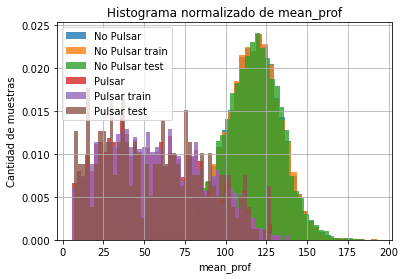

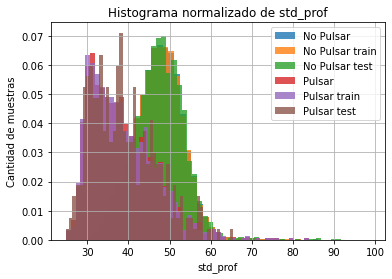

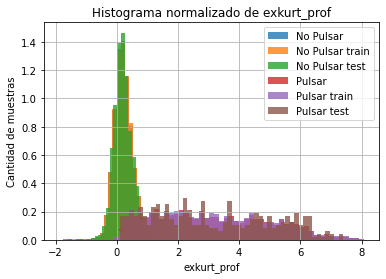

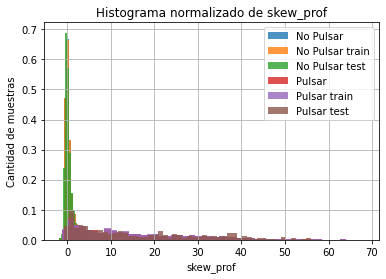

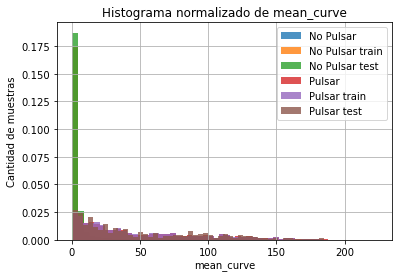

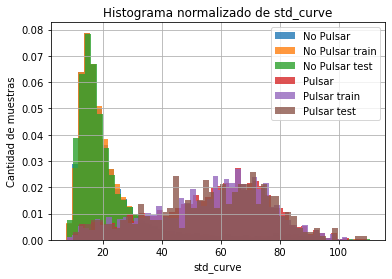

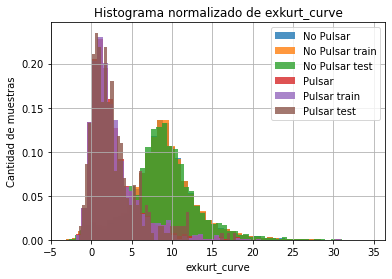

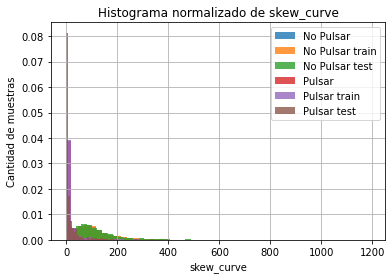

In [8]:
for i in range(len(headers)-1):
    X_train, X_test, _, _ = train_test_split(no_pulsar, 0.8, seed)

    ax = plt.subplot()
    ax.hist(no_pulsar[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar')
    ax.hist(X_train[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar train')
    ax.hist(X_test[headers[i]], 50, alpha=0.8, density=True, label='No Pulsar test')

    X_train, X_test, _, _ = train_test_split(pulsar, 0.8, seed)

    ax.hist(pulsar[headers[i]], 50, alpha=0.8, density=True, label='Pulsar')
    ax.hist(X_train[headers[i]], 50, alpha=0.8, density=True, label='Pulsar train')
    ax.hist(X_test[headers[i]], 50, alpha=0.8, density=True, label='Pulsar test')

    ax.set_xlabel(headers[i])
    ax.set_ylabel('Cantidad de muestras')
    ax.set_title(f'Histograma normalizado de {headers[i]}')
    ax.legend()
    ax.grid(True)
    plt.show()

El primer clasificador a implementar corresponde a ***naive bayes***. Este último tiene como hipótesis que todas las características presentes en un vector de características son independientes. De este modo, la probabilidad conjunta de un vector aleatorio equivale al producto de la probabilidad de cada variable aleatoria.

Para el entrenamiento y predicción se prefiere usar arreglos de numpy en lugar de DataFrames, debido a que el primero permite entregar resultados en un tiempo más eficiente.

Por medio de histogramas normalizados para cada clase, es posible obtener la probabilidad condicional de cada característica dada una clase.

In [9]:
def get_histograms(data, b=50):
    histograms = []

    for i in range(len(headers) - 1):
        histograms.append(np.histogram(data[:,i], bins=b, density=True))
    
    return histograms

Gracias a lo anterior es posible realizar el entrenamiento, el cual consiste en obtener una densidad de probabilidad para cada característica dada cada clase.

En el entrenamiento y la predicción, se asume que el problema a resolver es de clasificación binaria, por lo que sólo hay 2 clases.

In [10]:
def training(*train, b=50):
    X_0 = []
    X_1 = []

    # En caso de entregar sólo un conjunto, se separa en 2 clases.
    if len(train) == 1:
        X_0, X_1 = class_split(train)
    # Ya fueron entregados los datos de las 2 clases.
    else:
        X_0, X_1 = train
    
    # Se crea un conjunto de histogramas para cada clase.
    hists_0 = get_histograms(X_0, b)
    hists_1 = get_histograms(X_1, b)

    return hists_0, hists_1

Estando listo el entrenamiento, sigue implementar una forma de obtener una predicción. Para ello, se requiere que por cada vector de características, sea posible obtener su probabilidad de pertenencia a cada clase.

In [11]:
def search_probability(histogram, x):
    # Si la característica se encuentra fuera del rango, se entrega una probabilidad pequeña.
    if x < histogram[1][0] or x > histogram[1][-1]:
        return 0.0000001
    
    # Se busca el bin en el que se encuentra la característica x.
    step = histogram[1][1] - histogram[1][0]
    index = int((x - histogram[1][0])/step) - 1

    # Si la probabilidad es menor a una tolerancia, entregar esa tolerancia.
    if histogram[0][index] < 0.0000001:
        return 0.0000001
    
    return histogram[0][index]


def get_likelihood(histograms, vector_x):

    # Por el supuesto de naive bayes, la probabilidad conjunto es el producto de las probabilidades marginales.
    probability = np.prod([search_probability(histograms[i], vector_x[i]) for i in range(len(histograms))])
    return probability

Ahora para la predicción, se utiliza la regla de decisión del clasificador bayesiano, y se entrega un array con las predicciones de todas las muestras del conjunto de test, y otro array con las etiquetas respectivas.

In [12]:
def predict(test, *hists, theta):
    num_samples = test.shape[0]

    # Se separan los datos de test en etiquetas y muestras.
    labels = test[:,-1]
    samples = test[:,:-1]

    prediction = np.zeros(num_samples)
    for i in range(num_samples):
        likelihood_0 = get_likelihood(hists[0], samples[i])
        likelihood_1 = get_likelihood(hists[1], samples[i])

        # Equivalente a preguntar si P(X|clase 0)/P(X|clase 1) > theta
        if likelihood_0 > theta*likelihood_1:
            prediction[i] = 0
        else:
            prediction[i] = 1
    
    return prediction, labels

Una vez lista la predicción, una forma de conocer el desempeño del clasificador es la matriz de confusión. A través de ella, se puede visualizar cuánto acertó y cuánto falló el clasificador.

In [13]:
def confusion_matrix(prediction, labels):
    num_samples = prediction.shape[0]
    
    # [[TP, FP], [FN, TN]]
    cfn_mtx = np.zeros((2,2))

    for i in range(num_samples):
        if prediction[i] == 1 and labels[i] == 1:
            cfn_mtx[0,0] += 1
        elif prediction[i] == 1 and labels[i] == 0:
            cfn_mtx[0,1] += 1
        elif prediction[i] == 0 and labels[i] == 1:
            cfn_mtx[1,0] += 1
        else:
            cfn_mtx[1,1] += 1

    return cfn_mtx

La curva ROC corresponde a otra forma de visualizar el desempeño del clasificador. Ésta realiza una comparación entre la cantidad de errores de tipo 1 y errores de tipo 2 para cada theta.

Además, por medio del área bajo esta curva es posible obtener una métrica con la que se puede comparar directamente con otros clasificadores.

In [14]:
def ROC_curve(test, *hists):
    # El primer punto de la curva es el (0,0).
    FPR, TPR = [0], [0]

    # Cada uno de los umbrales usados para construir la curva.
    thetas = np.logspace(-10, 10, num=100)

    for theta in thetas:
        # Se obtienen las predicciones y se calcula la matriz de confusión.
        prediction, labels = predict(test, *hists, theta=theta)
        cfn_mtx = confusion_matrix(prediction, labels)

        # Se agregan las tasas de falsos positivos y verdaderos positivos a la curva.
        num_true_labels, num_false_labels = np.sum(cfn_mtx, axis=0)
        FPR.append(cfn_mtx[0,1]/num_false_labels)
        TPR.append(cfn_mtx[0,0]/num_true_labels)
    
    # El último punto de la curva es el (1,1).
    FPR.append(1)
    TPR.append(1)

    return FPR, TPR

A modo de visualización de la curva se ha implementado la siguiete función. Además, permite graficar más de una curva en caso de querer comparar distintos clasificadores.

In [15]:
def plot_ROC(*ROC_curves, labels=None):
    ax = plt.subplot()
    for curve in ROC_curves:
        ax.plot(curve[0], curve[1])
    
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Curva ROC")
    ax.grid(True)

    if labels is not None:
        ax.legend(labels)

    plt.show()

Análoga a la curva ROC, la curva Precision Recall (PR) permite medir el desempeño de un clasificador por medio de un trade off entre la métrica precision (capacidad de asignarle clase positiva sólo a muestras con clase positiva), y recall (la capacidad de encontrar todas las muestras positivas).

In [16]:
def PR_curve(test, *hists):
    # El primer punto de la curva es el (0,1).
    precision, recall = [1], [0]

    # Cada uno de los umbrales usados para construir la curva.
    thetas = np.logspace(-10, 10, num=100)

    for theta in thetas:
        # Se obtienen las predicciones y se calcula la matriz de confusión.
        prediction, labels = predict(test, *hists, theta=theta)
        cfn_mtx = confusion_matrix(prediction, labels)

        # Se agregaun nuevo punto a la curva.
        positive_prediction = cfn_mtx[0,0] + cfn_mtx[0,1]

        # En caso de no clasificar ninguna muestra como positiva, precision es 0.
        if not positive_prediction:
            precision.append(0)
        else:
            precision.append(cfn_mtx[0,0]/positive_prediction)
        recall.append(cfn_mtx[0,0]/(cfn_mtx[0,0] + cfn_mtx[1,0]))
    
    precision.append(0)
    recall.append(1)

    return recall, precision

Al igual que en el caso de la curva ROC, se ha programado una función que permite graficar una o varias curvas PR.

In [17]:
def plot_PR(*PR_curves, labels=None):
    ax = plt.subplot()

    for curve in PR_curves:
        ax.plot(curve[0], curve[1])

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Curva Precision Recall")
    ax.grid(True)

    if labels is not None:
        ax.legend(labels)
    
    plt.show()

Con todo lo anterior, es posible obtener ambas curvas para un clasificador.

In [18]:
X_0, X_1, X_test = train_test_split(data, 0.8, seed=seed, by_class=True)
X_0 = np.array(X_0); X_1 = np.array(X_1); X_test = np.array(X_test)

hists_0, hists_1 = training(X_0, X_1)
FPR, TPR = ROC_curve(X_test, hists_0, hists_1)
recall, precision = PR_curve(X_test, hists_0, hists_1)

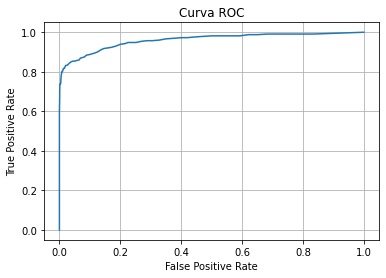

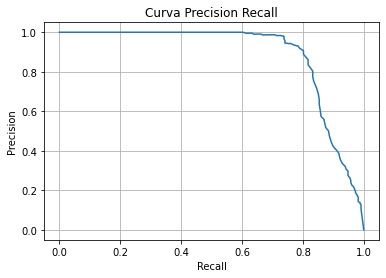

In [19]:
plot_ROC((FPR, TPR))
plot_PR((recall, precision))


Debido a que las probabilidades requeridas para el clasificador se obtuvieron por medio de histogramas, existe una dependencia entre el desempeño del clasificador y la cantidad de bins que se utilizan en el histograma. Para visualizar esta dependencia, primero se graficaran distintos histogramas para una característica variando la cantidad de bins, seguido de un gráfico con las curvas ROC de cada clasificador entrenado con distinto número de bins.

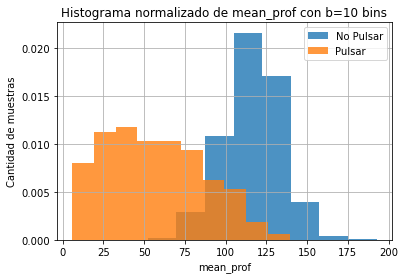

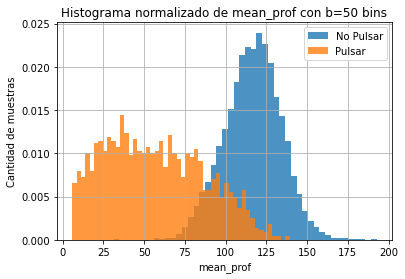

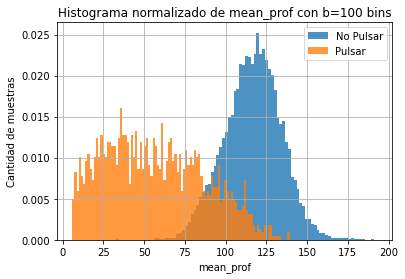

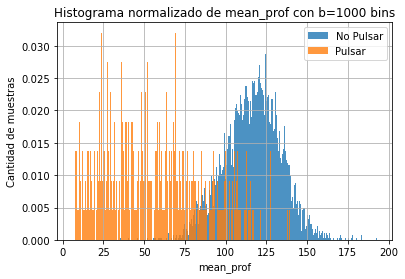

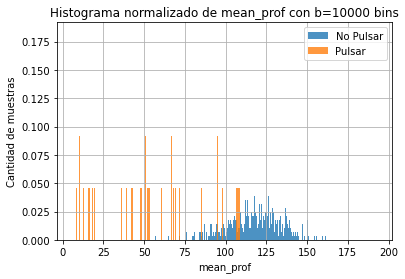

In [20]:
bins = [10, 50, 100, 1000, 10000]
for i in range(len(bins)):

    ax = plt.subplot()
    ax.hist(no_pulsar[headers[0]], bins=bins[i], alpha=0.8, density=True, label='No Pulsar')
    ax.hist(pulsar[headers[0]], bins=bins[i], alpha=0.8, density=True, label='Pulsar')

    ax.set_xlabel(headers[0])
    ax.set_ylabel('Cantidad de muestras')
    ax.set_title(f'Histograma normalizado de {headers[0]} con b={bins[i]} bins')
    ax.legend()
    ax.grid(True)
    plt.show()

In [21]:
ROC_curves = []
PR_curves = []
labels = []

for i in range(len(bins)):
    h0, h1 = training(X_0, X_1, b=bins[i])
    fpr, tpr = ROC_curve(X_test, h0, h1)
    rec, prec = PR_curve(X_test, h0, h1)
    
    ROC_curves.append((fpr, tpr))
    PR_curves.append((rec, prec))
    labels.append(f"{bins[i]} bins")

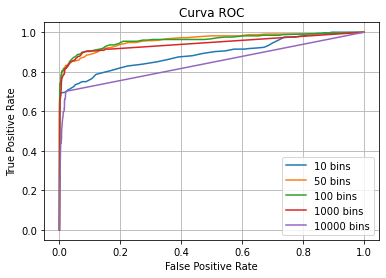

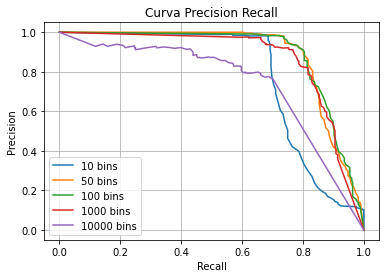

In [22]:
plot_ROC(*ROC_curves, labels=labels)
plot_PR(*PR_curves, labels=labels)


El segundo clasificador se ha construido bajo el supuesto de gaussianidad: para cada clase, los vectores de características distribuyen como gaussianas multidimensionales. De esta forma, para encontrar las probabilidades necesarias se requiere obtener una densidad de probabilidad conjunta.

In [23]:
def gaussian_training(*train):
    X_0 = []
    X_1 = []

    # En caso de entregar sólo un conjunto, se separa en 2 clases.
    if len(train) == 1:
        X_0, X_1 = class_split(train)
    # Ya fueron entregados los datos de las 2 clases.
    else:
        X_0, X_1 = train
    
    # Se eliminan las etiquetas ahora que los conjuntos se separaron por clase.
    X_0 = X_0[:,:-1]
    X_1 = X_1[:,:-1]

    def multivariate_normal(x, mean, cov):
        n = x.shape[0]
        inverse_cov = np.linalg.inv(cov)
        cov_det = np.linalg.det(cov)
        exponential_term = (-1/2)*((((x - mean).T).dot(inverse_cov)).dot(x - mean))
        return np.exp(exponential_term)/(((2*np.pi)**(n/2))*(cov_det**(1/2)))
        
    gaussian_pdf0 = lambda x: multivariate_normal(x, np.mean(X_0, axis=0), np.cov(X_0.T))
    gaussian_pdf1 = lambda x: multivariate_normal(x, np.mean(X_1, axis=0), np.cov(X_1.T))

    return gaussian_pdf0, gaussian_pdf1

Con las densidades de probabilidad que entrega el entrenamiento es posible realizar predicciones sobre el conjunto de test.

In [24]:
def gaussian_predict(test, *gaussian_pdfs, theta):
    num_samples = test.shape[0]
    labels = test[:,-1]
    samples = test[:, 0:-1]

    prediction = np.zeros(num_samples)
    for i in range(num_samples):
        likelihood_0 = gaussian_pdfs[0](samples[i])
        likelihood_1 = gaussian_pdfs[1](samples[i])

        if likelihood_0 > theta*likelihood_1:
            prediction[i] = 0
        else:
            prediction[i] = 1
    
    return prediction, labels

Al igual que con el clasificador naive bayes, se puede constuir una curva ROC.

In [25]:
def gaussian_ROC_curve(test, *pdfs):
    # El primer punto de la curva es el (0,0).
    FPR, TPR = [0], [0]

    # Cada uno de los umbrales usados para construir la curva.
    thetas = np.logspace(-10, 10, num=100)

    for theta in thetas:
        # Se obtienen las predicciones y se calcula la matriz de confusión.
        prediction, labels = gaussian_predict(test, *pdfs, theta=theta)
        cfn_mtx = confusion_matrix(prediction, labels)

        # Se agregan las tasas de falsos positivos y verdaderos positivos a la curva.
        num_true_labels, num_false_labels = np.sum(cfn_mtx, axis=0)
        FPR.append(cfn_mtx[0,1]/num_false_labels)
        TPR.append(cfn_mtx[0,0]/num_true_labels)
    
    # El último punto de la curva es el (1,1).
    FPR.append(1)
    TPR.append(1)

    return FPR, TPR

También se puede obtener una curva PR para este clasificador.

In [26]:
def gaussian_PR_curve(test, *pdfs):
    # El primer punto de la curva es el (0,1).
    precision, recall = [1], [0]

    # Cada uno de los umbrales usados para construir la curva.
    thetas = np.logspace(-10, 10, num=100)

    for theta in thetas:
        # Se obtienen las predicciones y se calcula la matriz de confusión.
        prediction, labels = gaussian_predict(test, *pdfs, theta=theta)
        cfn_mtx = confusion_matrix(prediction, labels)

        # Se agregaun nuevo punto a la curva.
        positive_prediction = cfn_mtx[0,0] + cfn_mtx[0,1]

        # En caso de no clasificar ninguna muestra como positiva, precision es 0.
        if not positive_prediction:
            precision.append(0)
        else:
            precision.append(cfn_mtx[0,0]/positive_prediction)
        recall.append(cfn_mtx[0,0]/(cfn_mtx[0,0] + cfn_mtx[1,0]))
    
    precision.append(0)
    recall.append(1)

    return recall, precision

Usando los mismos conjuntos de entrenamiento y test que el clasificador anterior, se obtienen las siguientes curvas.

In [27]:
pdf0, pdf1 = gaussian_training(X_0, X_1)
FPR, TPR = gaussian_ROC_curve(X_test, pdf0, pdf1)
recall, precision = gaussian_PR_curve(X_test, pdf0, pdf1)

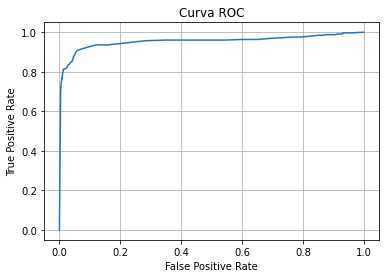

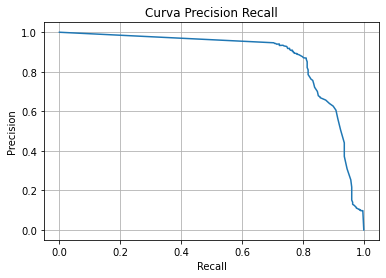

In [28]:
plot_ROC((FPR, TPR))
plot_PR((recall, precision))


Finalmente, para comparar las curvas ROC y PR de ambos clasificadores se puede generar un conjunto de entrenamiento, uno de test, y utilizarlos como argumentos de esta última función.

In [29]:
def get_curves(*train, test):
    hists_0, hists_1 = training(*train)
    naive_FPR, naive_TPR = ROC_curve(test, hists_0, hists_1)
    naive_recall, naive_precision = PR_curve(test, hists_0, hists_1)

    pdf0, pdf1 = gaussian_training(*train)
    gaussian_FPR, gaussian_TPR = gaussian_ROC_curve(test, pdf0, pdf1)
    gaussian_recall, gaussian_precision = gaussian_PR_curve(test, pdf0, pdf1)

    ROC_curves = [(naive_FPR, naive_TPR), (gaussian_FPR, gaussian_TPR), ([0,0,1], [0,1,1])]
    PR_curves = [(naive_recall, naive_precision), (gaussian_recall, gaussian_precision), ([1,1,0], [0,1,1])]
    labels = ["Clasificador Naive Bayes", "Clasificador gaussiano", "Clasificador perfecto"]

    plot_ROC(*ROC_curves, labels=labels)
    plot_PR(*PR_curves, labels=labels)    

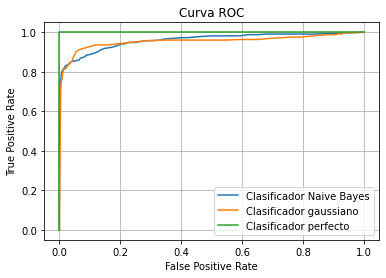

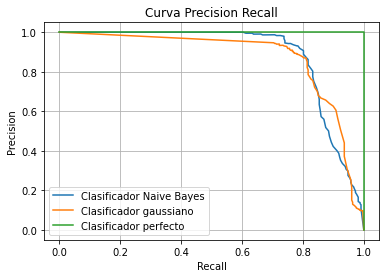

In [30]:
get_curves(X_0, X_1, test=X_test)
